In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import skew, kurtosis
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
import plotly.express as px
from scipy import stats
import os

In [28]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
base_dir = "/content/ds_Surya_kommu1"
os.makedirs(base_dir + "/csv_files", exist_ok=True)
os.makedirs(base_dir + "/outputs", exist_ok=True)

In [30]:
#Hyperliquid Trader Data
trader_data_url = "https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
trader_df = pd.read_csv(trader_data_url)
print("Trader Data shape:", trader_df.shape)
trader_df.head(3)

Trader Data shape: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


In [31]:
#Bitcoin Market Sentiment
sentiment_url = "https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"
sentiment_df = pd.read_csv(sentiment_url)
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
print("Sentiment Data shape:", sentiment_df.shape)
display(sentiment_df.head(3))

Sentiment Data shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


In [32]:
def data_overview(df, name):
    print(f"\n{name} Dataset Overview:")
    print("-"*50)
    print("Columns:", df.columns.tolist())
    print("\nInfo:")
    print(df.info())
    print("\nMissing values:\n", df.isnull().sum())
    print("\nDuplicates:", df.duplicated().sum())
    print("\nDescriptive Statistics:\n", df.describe(include='all').T)

data_overview(sentiment_df, "Sentiment")
data_overview(trader_df, "Trader")


Sentiment Dataset Overview:
--------------------------------------------------
Columns: ['timestamp', 'value', 'classification', 'date']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       2644 non-null   int64         
 1   value           2644 non-null   int64         
 2   classification  2644 non-null   object        
 3   date            2644 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 82.8+ KB
None

Missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicates: 0

Descriptive Statistics:
                  count unique   top freq                           mean  \
timestamp       2644.0    NaN   NaN  NaN              1631898885.022693   
value           2644.0    NaN   NaN  NaN                    

In [33]:
#Fill missing numerical values with median
num_cols_sentiment = sentiment_df.select_dtypes(include=np.number).columns
sentiment_df[num_cols_sentiment] = sentiment_df[num_cols_sentiment].fillna(sentiment_df[num_cols_sentiment].median())

num_cols_trader = trader_df.select_dtypes(include=np.number).columns
trader_df[num_cols_trader] = trader_df[num_cols_trader].fillna(trader_df[num_cols_trader].median())

In [34]:
# Outlier Detection and Treatment
def detect_outliers_zscore(df, threshold=3):
    """
    Detects outliers using Z-score method for numerical columns.
    Returns a dictionary with column names and number of outliers detected.
    """
    num_cols = df.select_dtypes(include=np.number).columns
    outliers = {}
    for col in num_cols:
        z_scores = np.abs(stats.zscore(df[col]))
        outliers_count = np.sum(z_scores > threshold)
        outliers[col] = outliers_count
    return outliers

def detect_outliers_iqr(df):
    """
    Detects outliers using IQR method.
    Returns a dictionary with column names and number of outliers detected.
    """
    num_cols = df.select_dtypes(include=np.number).columns
    outliers = {}
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        outliers[col] = outliers_count
    return outliers

def cap_outliers_iqr(df):
    """
    Caps outliers to the nearest non-outlier values using IQR method.
    """
    num_cols = df.select_dtypes(include=np.number).columns
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Detect Outliers
print("Sentiment Dataset Outliers (Z-score):", detect_outliers_zscore(sentiment_df))
print("Sentiment Dataset Outliers (IQR):", detect_outliers_iqr(sentiment_df))

print("Trader Dataset Outliers (Z-score):", detect_outliers_zscore(trader_df))
print("Trader Dataset Outliers (IQR):", detect_outliers_iqr(trader_df))

# Fix Outliers
sentiment_df = cap_outliers_iqr(sentiment_df)
trader_df = cap_outliers_iqr(trader_df)

print("\nOutliers have been capped using IQR method.")

# Verify Outliers After Treatment

print("Sentiment Dataset Outliers After Capping (IQR):", detect_outliers_iqr(sentiment_df))
print("Trader Dataset Outliers After Capping (IQR):", detect_outliers_iqr(trader_df))


Sentiment Dataset Outliers (Z-score): {'timestamp': np.int64(0), 'value': np.int64(0)}
Sentiment Dataset Outliers (IQR): {'timestamp': 0, 'value': 0}
Trader Dataset Outliers (Z-score): {'Execution Price': np.int64(1598), 'Size Tokens': np.int64(378), 'Size USD': np.int64(1525), 'Start Position': np.int64(2014), 'Closed PnL': np.int64(854), 'Order ID': np.int64(6458), 'Fee': np.int64(2051), 'Trade ID': np.int64(0), 'Timestamp': np.int64(8010)}
Trader Dataset Outliers (IQR): {'Execution Price': 42187, 'Size Tokens': 34744, 'Size USD': 32661, 'Start Position': 58346, 'Closed PnL': 48941, 'Order ID': 9213, 'Fee': 30278, 'Trade ID': 0, 'Timestamp': 77353}

Outliers have been capped using IQR method.
Sentiment Dataset Outliers After Capping (IQR): {'timestamp': 0, 'value': 0}
Trader Dataset Outliers After Capping (IQR): {'Execution Price': 0, 'Size Tokens': 0, 'Size USD': 0, 'Start Position': 0, 'Closed PnL': 0, 'Order ID': 0, 'Fee': 0, 'Trade ID': 0, 'Timestamp': 0}


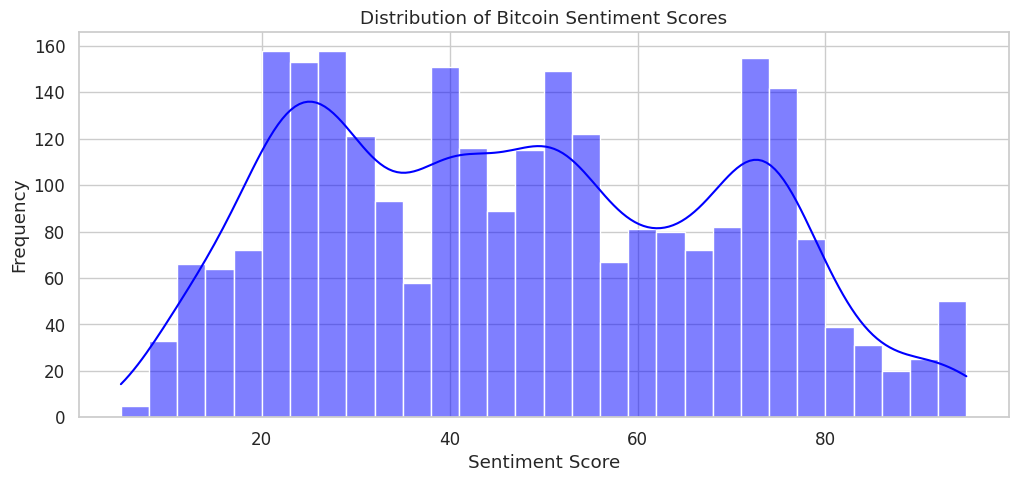

In [35]:
# Sentiment Analysis Plots
plt.figure(figsize=(12,5))
sns.histplot(sentiment_df['value'], bins=30, kde=True, color='blue')
plt.title("Distribution of Bitcoin Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.savefig(base_dir + "/outputs/Sentiment Analysis Plots.png")
plt.show()

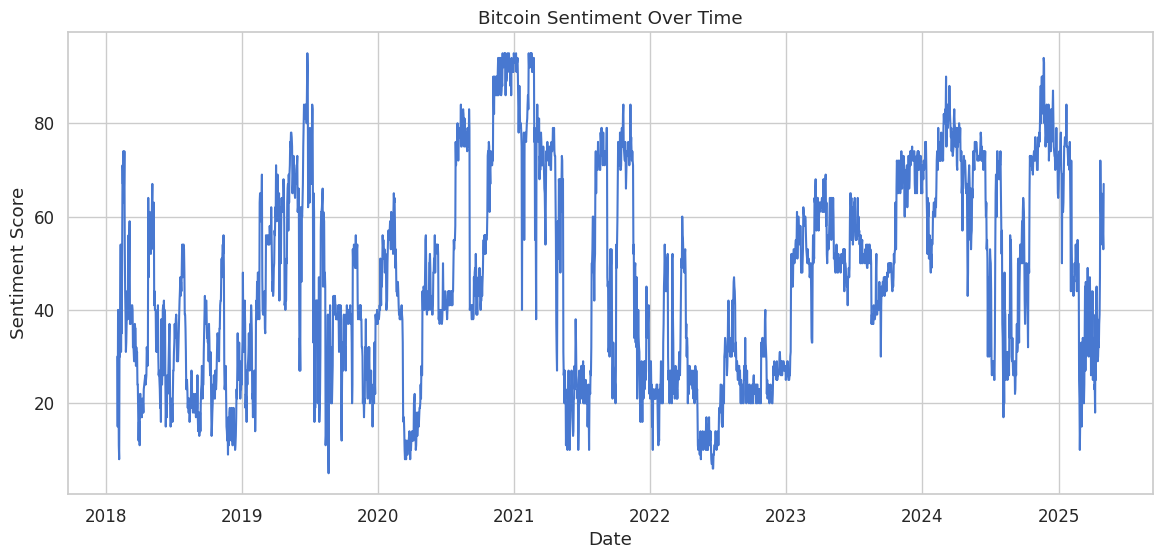

In [36]:
# Sentiment over time
plt.figure(figsize=(14,6))
sns.lineplot(x='date', y='value', data=sentiment_df)
plt.title("Bitcoin Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.savefig(base_dir + "/outputs/Sentiment over time.png")
plt.show()

In [37]:
# Trader Data Analysis
# Total trades over time
if 'trade_date' in trader_df.columns:
    trader_df['trade_date'] = pd.to_datetime(trader_df['trade_date'])
    trades_over_time = trader_df.groupby('trade_date').size().reset_index(name='total_trades')

    plt.figure(figsize=(14,6))
    sns.lineplot(x='trade_date', y='total_trades', data=trades_over_time)
    plt.title("Number of Trades Over Time")
    plt.xlabel("Date")
    plt.ylabel("Total Trades")
    plt.show()

In [38]:
# Trader distribution by type (if column exists)
if 'trader_type' in trader_df.columns:
    plt.figure(figsize=(10,5))
    sns.countplot(x='trader_type', data=trader_df)
    plt.title("Distribution of Trader Types")
    plt.show()

In [39]:
# Correlation Analysis
# Combine datasets for correlation.
if 'trade_date' in trader_df.columns:
    combined_df = trader_df.groupby('trade_date').size().reset_index(name='total_trades')
    combined_df = combined_df.merge(sentiment_df[['date','sentiment_score']], left_on='trade_date', right_on='date', how='inner')

    plt.figure(figsize=(8,6))
    sns.scatterplot(x='sentiment_score', y='total_trades', data=combined_df)
    plt.title("Sentiment vs Total Trades")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Total Trades")
    plt.show()

    corr = combined_df[['sentiment_score','total_trades']].corr()
    print("Correlation between Sentiment and Total Trades:\n", corr)

In [40]:
#Statistical Insights
def stats_summary(col):
    print(f"\nStatistics for {col}:")
    print(f"Mean: {col.mean():.4f}")
    print(f"Median: {col.median():.4f}")
    print(f"Std Dev: {col.std():.4f}")
    print(f"Skewness: {skew(col):.4f}")
    print(f"Kurtosis: {kurtosis(col):.4f}")

if 'sentiment_score' in sentiment_df.columns:
    stats_summary(sentiment_df['sentiment_score'])

if 'trade_amount' in trader_df.columns:
    stats_summary(trader_df['trade_amount'])

In [41]:
# Convert trader timestamp to datetime
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'], unit='ms')
trader_df['date'] = trader_df['Timestamp'].dt.date

In [42]:
#Merge trader data with market sentiment
trader_df['date'] = pd.to_datetime(trader_df['date'])
merged_df = trader_df.merge(sentiment_df, left_on='date', right_on='date', how='left')
merged_df.to_csv(base_dir + "/csv_files/merged_sentiment_trader_data.csv", index=False)

In [43]:
print(merged_df.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date', 'timestamp', 'value', 'classification'],
      dtype='object')


In [44]:
merged_df.columns = merged_df.columns.str.strip()

# Rename columns
merged_df.rename(columns={
    'Closed PnL': 'closed_pnl_usd',
    'Size USD': 'size_usd',
    'value': 'sentiment_score'
}, inplace=True)


merged_df['size_usd'] = pd.to_numeric(merged_df['size_usd'], errors='coerce')
merged_df['Start Position'] = pd.to_numeric(merged_df['Start Position'], errors='coerce') # Ensure 'Start Position' is numeric

merged_df['leverage'] = merged_df['size_usd'] / merged_df['Start Position'].abs()
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)

merged_df['leverage'] = pd.to_numeric(merged_df['leverage'], errors='coerce')

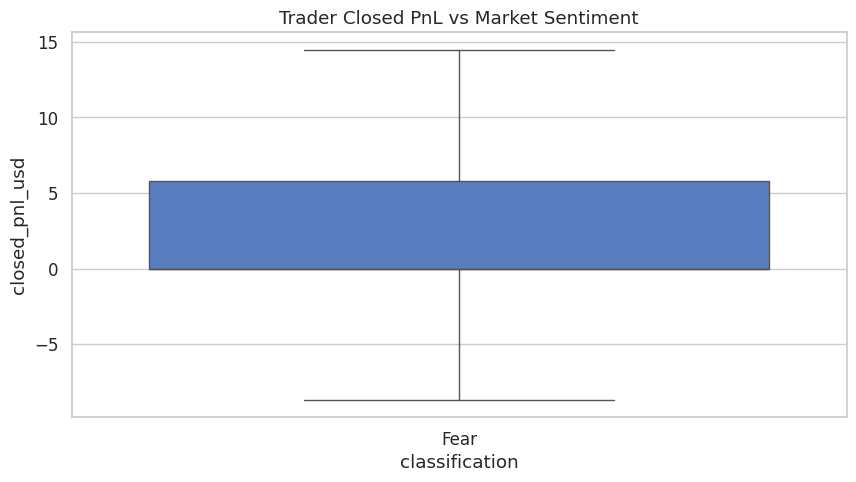

In [45]:
# PnL distribution
plt.figure(figsize=(10,5))
sns.boxplot(x='classification', y='closed_pnl_usd', data=merged_df)
plt.title("Trader Closed PnL vs Market Sentiment")
plt.savefig(base_dir + "/outputs/pnl_distribution.png")
plt.show()

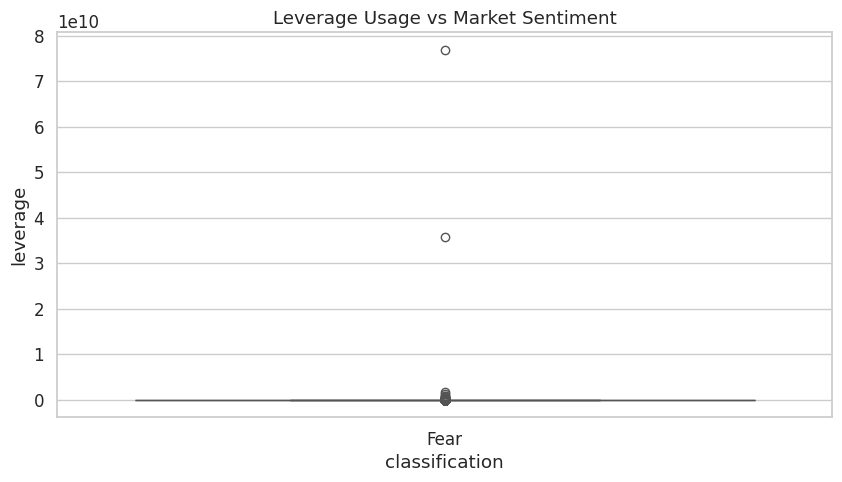

In [46]:
# Leverage vs Sentiment
plt.figure(figsize=(10,5))
sns.boxplot(x='classification', y='leverage', data=merged_df)
plt.title("Leverage Usage vs Market Sentiment")
plt.savefig(base_dir + "/outputs/leverage_vs_sentiment.png")
plt.show()

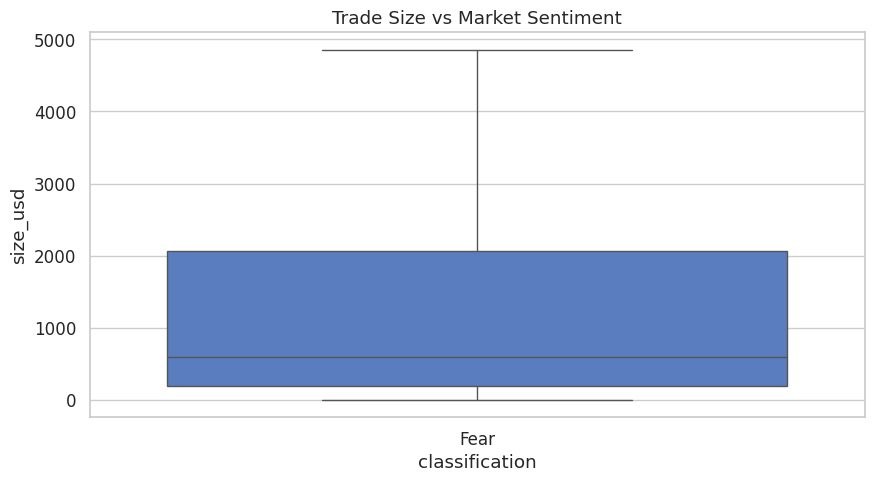

In [47]:
# Trade size vs Sentiment
plt.figure(figsize=(10,5))
sns.boxplot(x='classification', y='size_usd', data=merged_df)
plt.title("Trade Size vs Market Sentiment")
plt.savefig(base_dir + "/outputs/trade_size_vs_sentiment.png")
plt.show()

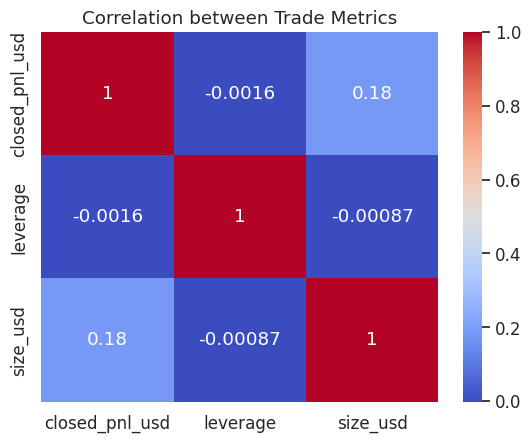

In [48]:
# Step 6: Correlation Analysis
corr_df = merged_df[['closed_pnl_usd','leverage','size_usd']].corr()
sns.heatmap(corr_df, annot=True, cmap="coolwarm")
plt.title("Correlation between Trade Metrics")
plt.savefig(base_dir + "/outputs/trade_sentiment_correlation.png")
plt.show()

In [49]:
# Step 7: Summary Statistics
summary_stats = merged_df.groupby('classification')[['closed_pnl_usd','leverage','size_usd']].describe()
summary_stats.to_csv(base_dir + "/csv_files/summary_stats.csv")
summary_stats

closed_pnl_usd                                         \
                        count     mean       std       min  25%  50%   
classification                                                         
Fear                 211224.0  3.13394  6.354911 -8.689195  0.0  0.0   

                                     leverage                 ...            \
                     75%        max     count           mean  ...       75%   
classification                                                ...             
Fear            5.792797  14.481992  207139.0  597345.664003  ...  2.567305   

                              size_usd                                         \
                         max     count         mean          std  min     25%   
classification                                                                  
Fear            7.696000e+10  211224.0  1465.146534  1716.088616  0.0  193.79   

                                            
                    50%      75%       max  
classification                              
Fear            597.045  2058.96  4856.715  

[1 rows x 24 columns]

In [50]:
# Feature Engineering

# Sentiment moving average
merged_df['sentiment_ma7'] = merged_df['sentiment_score'].rolling(window=7).mean()

# Daily change in sentiment
merged_df['sentiment_change'] = merged_df['sentiment_score'].diff()

# Calculate trades per sentiment
# Group by date and count trades, then merge with sentiment data
daily_trades = merged_df.groupby('date').size().reset_index(name='total_trades')

# Merge daily_trades with merged_df to get sentiment_score per date
merged_with_daily_trades = daily_trades.merge(
    merged_df[['date', 'sentiment_score']].drop_duplicates(),
    on='date',
    how='left'
)

merged_df['trade_per_sentiment'] = merged_with_daily_trades['total_trades'] / (merged_with_daily_trades['sentiment_score'] + 1e-6)

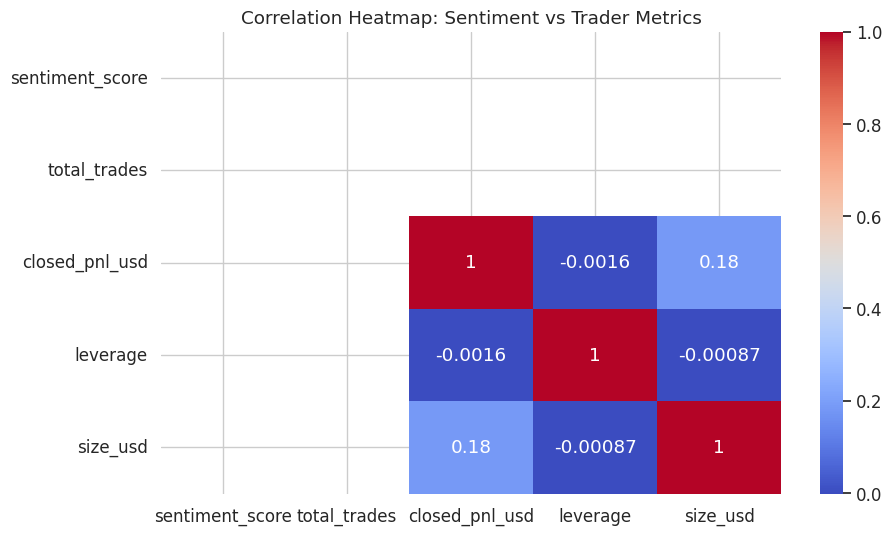

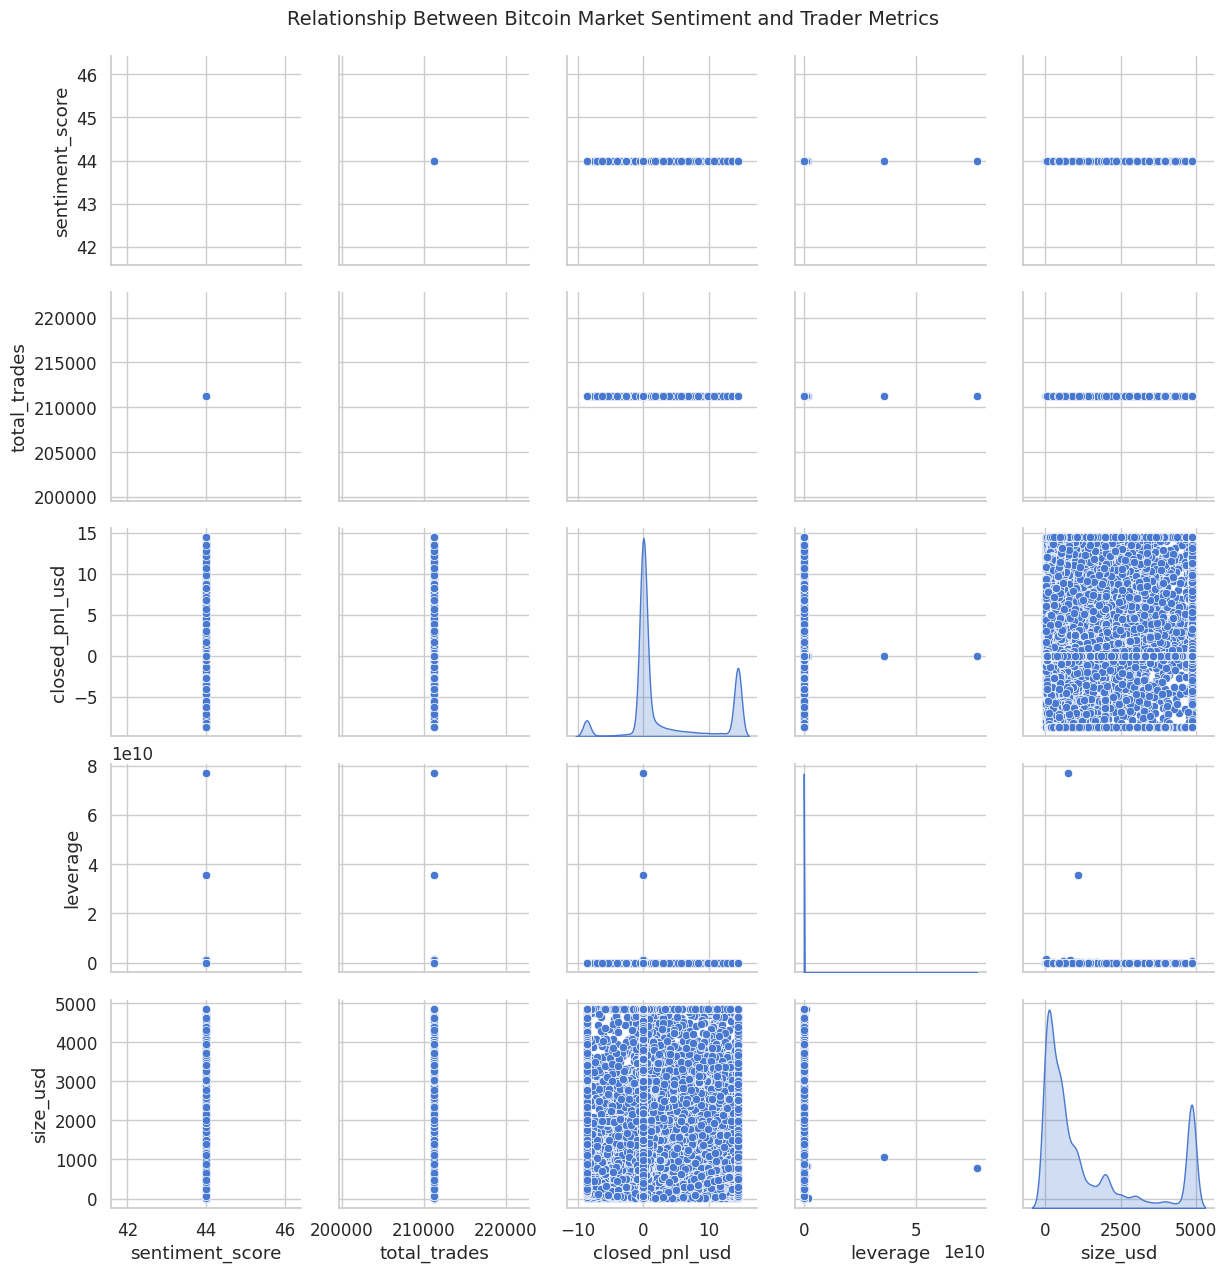

In [53]:
# Step 6: Correlation Analysis
merged_df_with_trades = merged_df.merge(daily_trades, on='date', how='left')

corr_df = merged_df_with_trades[['sentiment_score','total_trades', 'closed_pnl_usd','leverage','size_usd']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_df, cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap: Sentiment vs Trader Metrics")
plt.savefig(base_dir + "/outputs/HeatMap Sentiment Vs Trader Metrics .png")
plt.show()

# Removed'trade_amount'.
sns.pairplot(merged_df_with_trades[['sentiment_score','total_trades', 'closed_pnl_usd','leverage','size_usd']].dropna(), diag_kind='kde')
plt.suptitle("Relationship Between Bitcoin Market Sentiment and Trader Metrics", fontsize=14, y=1.02)
plt.savefig(base_dir + "/outputs/Relationship Between Bitcoin Market Sentiment and Total Trades.png")
plt.show()

In [54]:
 #Save processed trader data
trader_df.to_csv(base_dir + "/csv_files/processed_trader_data.csv",index =False)

In [55]:
trader_df.shape

(211224, 17)

In [56]:
trader_df.head(3)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,465.34625,4856.715,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,2025-02-19 21:20:00,2025-02-19
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00000,127.680,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,2025-02-19 21:20:00,2025-02-19
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09000,1150.630,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,2025-02-19 21:20:00,2025-02-19
